# IRL for PdN
- V.1.0 - 4-Aug-2024

In [42]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
# Custom libraries
from MT_environment import MillingTool_Env
from utilities import downsample, tool_wear_data

In [43]:
DATA_FILE = 'PHM_C01.csv'
WEAR_THRESHOLD = 0.12
SAMPLING_RATE = 10
ADD_NOISE = 0

EPISODES = 4000
BATCH_SIZE = 16
SAMPLE_DEMONSTRATIONS = 100
EVALUATION_ROUNDS = 10
TENSOR_BOARD = False
LOG_PATH = 'D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/'
# LOG_PATH = f'{PATH}/tensorboard/{now.strftime("%d-%b-%Y_%H_%M")}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'Tensorboard logging to {LOG_PATH}')

Tensorboard logging to D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/


- Down-sampling. Input data records: 1000. Sampling rate: 10. Expected rows 100.    Down-sampled to 100 rows.


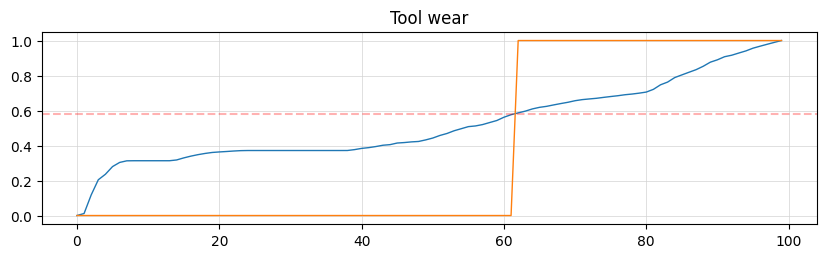

Tool failure RUL threshold at time 95 is 0.044


In [44]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MILLING_OPERATIONS_MAX = records

rul_threshold_record = int(0.95 * records)
rul_threshold = df_train.loc[df_train.index[rul_threshold_record], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record} is {rul_threshold:3.3f}')

## 1. Predictive maintenance environment

In [45]:
from stable_baselines3.common.env_checker import check_env

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = MillingTool_Env,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

mt_env = gym.make('custom/MillingToolEnv-v0', records=records, rul_threshold=rul_threshold)
# Check env. formation 
check_env(mt_env)


 -- Milling tool environment initiatlized. Potential records 100. RUL threshold 0.044


In [46]:
mt_env.tool_wear_data(df_train)


 - Milling tool environment: Tool wear data updated: 100


## 2. The "Human" Expert

In [47]:
if TENSOR_BOARD:
    expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
else:
    expert_ppo = PPO('MlpPolicy', env=mt_env)
    
expert_ppo.learn(EPISODES)

In [48]:
# if TENSOR_BOARD:
#     expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
# else:
#     expert_a2c = A2C('MlpPolicy', env=mt_env)

# expert_a2c.learn(EPISODES)

In [49]:
reward_ppo, _ = evaluate_policy(expert_ppo, mt_env, 5)
print(f'PPO Expert reward: {reward_ppo:4.2f}')

# reward_a2c, _ = evaluate_policy(expert_a2c, mt_env, 20)
# print(f'A2C Expert reward: {reward_a2c:4.2f}')

PPO Expert reward: 51.74


## 3. Train the student by applying IRL - using expert demonstrations

- Use the expert to sample some trajectories.
- Flatten them to obtain individual transitions for behavior cloning

#### Implementation details: 
- Use `imitation` utilities - Collect 50 episode rollouts, then flatten them to just the transitions that we need for training.
- `rollout` function requires a vectorized environment and needs the `RolloutInfoWrapper` around each of the environments
- This is why we passed the `post_wrappers` argument to `make_vec_env` above.

In [50]:
# Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
env_kwargs = {'records':records, 'rul_threshold':rul_threshold}

mt_venv = make_vec_env(
    'custom/MillingToolEnv-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
)


 -- Milling tool environment initiatlized. Potential records 0. RUL threshold 0.000

 -- Milling tool environment initiatlized. Potential records 100. RUL threshold 0.044


In [51]:
# Add tool wear data
mt_venv.reset()
mt_venv.step([1])

(array([[0., 0., 0., 0.]], dtype=float32),
 array([0.6], dtype=float32),
 array([ True]),
 [{'Step': 'RUL threshold crossed',
   'episode': {'r': 0.6, 'l': 1, 't': 0.015551},
   'rollout': {'obs': array([[0., 0., 0., 0.],
           [0., 0., 0., 0.]], dtype=float32),
    'rews': array([0.6])},
   'TimeLimit.truncated': False,
   'terminal_observation': array([0., 0., 0., 0.], dtype=float32)}])

### Add tool wear data
- IMPORTANT -- note how a vectorized env. methd is called
- NOT like this >>  mt_venv.tool_wear_data(df_train)

In [52]:
# Add tool wear data
# IMPORTANT -- note how a vectorized env. methd is called
# NOT like this >>  mt_venv.tool_wear_data(df_train)
mt_venv.env_method('tool_wear_data', df_train)


 - Milling tool environment: Tool wear data updated: 100


[None]

In [53]:
rng = np.random.default_rng()

rollouts = rollout.rollout(
    expert_ppo,
    mt_venv,
    rollout.make_sample_until(min_timesteps=None, min_episodes=SAMPLE_DEMONSTRATIONS),
    rng = rng,
)

demonstrations = rollout.flatten_trajectories(rollouts)

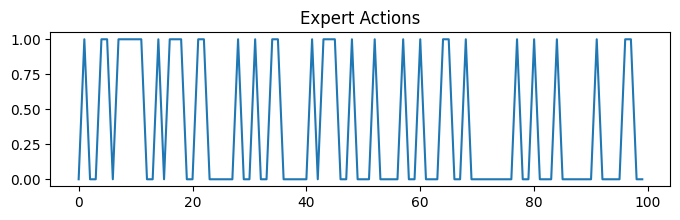

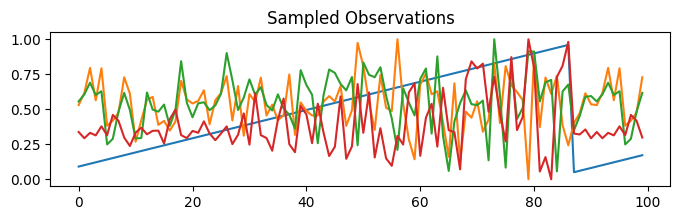

In [54]:
import matplotlib.pyplot as plt
obsvs = []
acts = []

for n in range(len(rollouts)):
    acts.append(demonstrations.acts[n])
    obsvs.append(demonstrations.obs[n])

plt.figure(figsize=(8, 2))
plt.title('Expert Actions')
plt.plot(acts)

plt.figure(figsize=(8, 2))
plt.title('Sampled Observations')
plt.plot(obsvs)

## 3.2 Set up IRL algorithm
- Set up our behavior cloning algorithm
- Compute rewards before showing expert demonstrations

In [55]:
from imitation.algorithms import bc
from imitation.util import logger as imit_logger

if TENSOR_BOARD:
    # Set new logger
    tmp_path_irl = f'{PATH}/tensorboard/irl_log/BC/'
    new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu',
        custom_logger = new_logger_irl)
else:
    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu')

In [56]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print(f"Reward before training: {reward_before_training: 4.3f}")

Reward before training:  29.627


## 3.3 Apply IRL - BC algo.
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm- 
Compute reward and compares befor/aftere showing expert demonstrations

In [57]:
bc_trainer.train(n_epochs=1)

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 16        |
---------------------------------


476batch [00:01, 373.27batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000622 |
|    entropy        | 0.622     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 73.9      |
|    loss           | 0.631     |
|    neglogp        | 0.632     |
|    prob_true_act  | 0.565     |
|    samples_so_far | 8016      |
---------------------------------


556batch [00:01, 371.23batch/s]
574batch [00:01, 367.07batch/s]


In [58]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")
reward_after_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)

print('-'*120)
print(' **** IRL with Imitation Libraries and Milling environment ****')
print('-'*120)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Rewards Before: {reward_before_training:5.3f} | After: {reward_after_training:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

------------------------------------------------------------------------------------------------------------------------
 **** IRL with Imitation Libraries and Milling environment ****
------------------------------------------------------------------------------------------------------------------------
06-Aug-2024  20:59:13
Episodes: 4000
Rewards Before: 29.627 | After: 51.720


## 3.3.b Apply IRL - SQIL algo.
- Use expert demonstrations and learn the reward function - using ## 3.3 Apply IRL (BC)
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm
- Compute rewards and compare before/after showing expert demonstrations algorithm
- Compute rewards and compare before/after showing expert demonstrations

In [61]:
from imitation.algorithms import sqil
from imitation.util import logger as imit_logger

if TENSOR_BOARD:
    # Set new logger
    tmp_path_irl = f'{PATH}/tensorboard/irl_log/SQIL/'
    new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])
    
    sqil_trainer = sqil.SQIL(   
        venv = mt_venv,
        demonstrations = transitions,
        policy='MlpPolicy',
        # device='cpu',
        custom_logger = new_logger_irl
    )
else: 
    sqil_trainer = sqil.SQIL(   
        venv = mt_venv,
        demonstrations = demonstrations,
        policy='MlpPolicy')

In [62]:
reward_before_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, EVALUATION_ROUNDS)

# Note: set to 1_000_000 to obtain good results
sqil_trainer.train(total_timesteps = EPISODES)  

reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, EVALUATION_ROUNDS)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Rewards Before: {reward_before_training:5.3f} | After: {reward_after_training:5.3f}')

06-Aug-2024  20:59:13
Episodes: 4000
Rewards Before: 51.724 | After: 51.673
